# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [289]:
import scipy as s
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [129]:
# Activity 2 - Use SciPy to calculate Bayesian confidence intervals
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bayes_mvs.html#scipy.stats.bayes_mvs

observations = np.array([[1,1], [2,2]])
print(s.stats.chisquare(observations, axis=None))

Power_divergenceResult(statistic=0.66666666666666663, pvalue=0.8810148425137847)


In [57]:
s.stats.normaltest(np.random.poisson(5, 1000))

NormaltestResult(statistic=56.066080767425873, pvalue=6.6896785603775779e-13)

In [90]:
tests = np.array([])

for _ in range(10):
    tsample = np.random.poisson(5, 1000)
    tests = np.append(tests, s.stats.normaltest(sample))

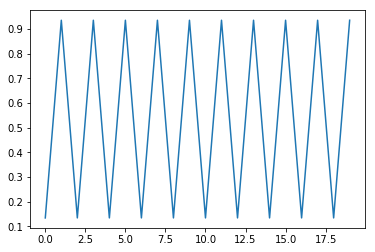

In [91]:
pd.Series(tests).plot.line()

In [50]:
pd.Series(tests).describe()

count    2.000000e+02
mean     1.580174e+01
std      1.584139e+01
min      1.372122e-07
25%      1.372122e-07
50%      1.580174e+01
75%      3.160348e+01
max      3.160348e+01
dtype: float64

In [56]:
sample = np.random.normal(size=1000)
s.stats.normaltest(sample)

NormaltestResult(statistic=0.13388221973464515, pvalue=0.93525027672794525)

In [70]:
X = pd.Series([1,2,3,4,5,6,7])
Y = pd.Series([1,2,3,4,5,6,7])

pd.DataFrame({'X': X, 'Y': Y}).describe()

,X,Y
count,7.000000,7.000000
mean,4.000000,4.000000
std,2.160247,2.160247
min,1.000000,1.000000
25%,2.500000,2.500000
50%,4.000000,4.000000
75%,5.500000,5.500000
max,7.000000,7.000000


In [73]:
s.stats.kruskal(X,Y)

KruskalResult(statistic=0.0, pvalue=1.0)

In [95]:
err_range = range(0,20)

stats = np.array([])
pvalues =  np.array([])

for err in err_range:
    X = pd.Series([1,2,3,4,5,6,7])
    err = X.apply(lambda x: x+err)
    stat, pvalue = s.stats.kruskal(X, err)
    stats = np.append(stats, stat)
    pvalues = np.append(pvalues, pvalue)

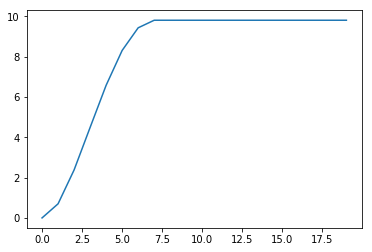

In [96]:
pd.Series(stats).plot.line()

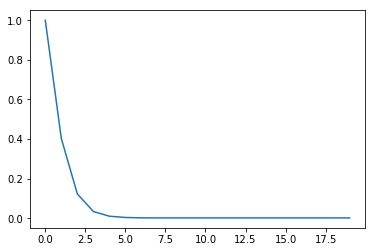

In [97]:
pd.Series(pvalues).plot.line()

And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

In [134]:
s.stats.chi2(5).mean()

5.0

In [124]:
s.stats.chi2(5).median()

4.3514601910955264

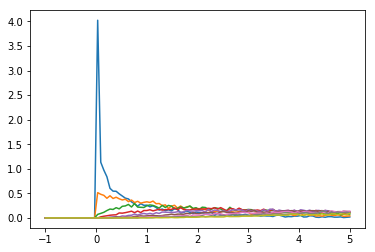

In [192]:
ax = plt.subplot(111)

for dof in range(1,10):
    sample = s.stats.chi2.rvs(size=10000, df=dof)
    x = np.linspace(-1.0, 5.0, 100)
    hist = np.histogram(sample, bins=400)
    dist = s.stats.rv_histogram(hist)
    ax.plot(x, dist.pdf(x))

In [165]:
upper = 10
parameters = range(1, upper)

xxs = np.empty([3, upper])

for p in parameters:
    d = s.stats.chi2(p)
    
    xxs[0][p] = d.mean()
    xxs[1][p] = d.median()
    xxs[2][p] = d.var()
    
means, medians, variances = xxs

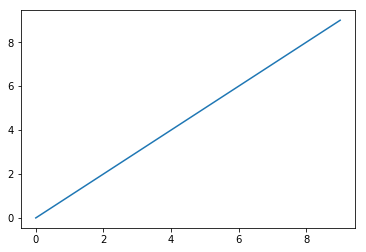

In [166]:
pd.Series(means).plot.line()

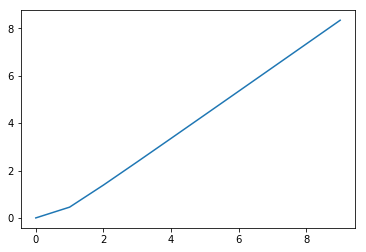

In [167]:
pd.Series(medians).plot.line()

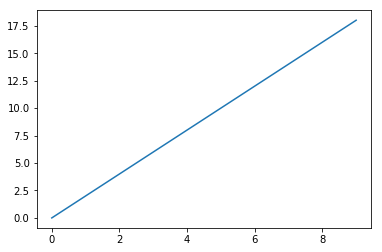

In [168]:
pd.Series(variances).plot.line()

In [215]:
coinflips = np.random.binomial(n=1, p=0.7, size=100)
ttest = s.stats.ttest_1samp(coinflips, 0.5)
ttest

Ttest_1sampResult(statistic=3.8393760982130183, pvalue=0.00021755831055227402)

In [212]:
coin_signifigances = pd.DataFrame()

for x in np.arange(0,1,0.01):
    t, p = s.stats.ttest_1samp(coinflips, x)
    coin_signifigances.loc[x, 't'] = t
    coin_signifigances.loc[x, 'p'] = p

In [220]:
coin_signifigances.describe()

,t,p
count,100.000000,1.000000e+02
mean,2.782148,7.829896e-02
std,5.978834,2.009618e-01
min,-7.419061,4.234970e-23
25%,-2.318457,4.629902e-12
50%,2.782148,1.315576e-06
75%,7.882753,1.025941e-02
max,12.983357,1.000000e+00


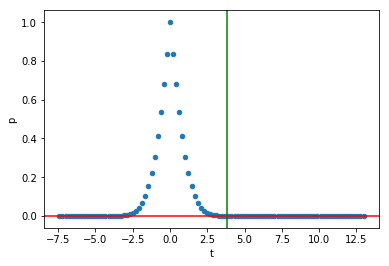

In [222]:
coin_signifigances.plot.scatter(x='t', y='p')
plt.axvline(ttest.statistic, color='g')
plt.axhline(ttest.pvalue, color='r')

In [231]:
def confidence_interval(sample, confidence=0.95):
    sample = np.array(sample)
    mean = np.mean(sample)
    err = s.stats.sem(sample)
    interval = err * s.stats.t.ppf((1+confidence)/2.0, sample.size-1)
    return (mean, mean-interval, mean+interval)

In [233]:
expectation, lower, upper = confidence_interval(coinflips)

Text(0.873025,0.9,'upper')

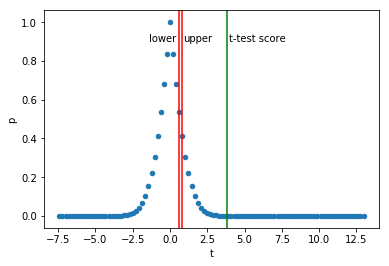

In [250]:
coin_signifigances.plot.scatter(x='t', y='p')
plt.axvline(ttest.statistic, color='g')
plt.text(ttest.statistic+0.1, 0.9, 't-test score',rotation=0)
plt.axvline(lower, color='r')
plt.text(lower-2, 0.9, 'lower',rotation=0)
plt.axvline(upper, color='r')
plt.text(upper+0.1, 0.9, 'upper',rotation=0)

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.

In [1]:
import scipy as s
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
titles = ""\
 + "handicapped-infants "\
 + "water-project-cost-sharing "\
 + "adoption-of-the-budget-resolution "\
 + "physician-fee-freeze el-salvador-aid "\
 + "religious-groups-in-schools "\
 + "anti-satellite-test-ban "\
 + "aid-to-nicaraguan-contras "\
 + "mx-missile immigration "\
 + "synfuels-corporation-cutback "\
 + "education-spending "\
 + "superfund-right-to-sue "\
 + "crime "\
 + "duty-free-exports "\
 + "export-administration-act-south-africa"

issues = titles.replace("-", "_").split(" ")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"
raw_votes = pd\
    .read_csv(url, header=None)\
    .rename(columns={0: 'affiliation'})\
    .rename(columns={k:v for k,v in list(zip(range(1,len(issues)+1), issues))})\
    .set_index('affiliation')

In [60]:
votes = raw_votes.replace({'?': np.nan, 'n': 0, 'y': 1})

In [5]:
dem = votes.loc['democrat']
rep = votes.loc['republican']

In [6]:
dem.describe().T

,count,mean,std,min,25%,50%,75%,max
handicapped_infants,258.0,0.604651,0.489876,0.0,0.0,1.0,1.0,1.0
water_project_cost_sharing,239.0,0.502092,0.501045,0.0,0.0,1.0,1.0,1.0
adoption_of_the_budget_resolution,260.0,0.888462,0.315405,0.0,1.0,1.0,1.0,1.0
physician_fee_freeze,259.0,0.054054,0.226562,0.0,0.0,0.0,0.0,1.0
el_salvador_aid,255.0,0.215686,0.412106,0.0,0.0,0.0,0.0,1.0
religious_groups_in_schools,258.0,0.476744,0.500430,0.0,0.0,0.0,1.0,1.0
anti_satellite_test_ban,259.0,0.772201,0.420224,0.0,1.0,1.0,1.0,1.0
aid_to_nicaraguan_contras,263.0,0.828897,0.377317,0.0,1.0,1.0,1.0,1.0
mx_missile,248.0,0.758065,0.429121,0.0,1.0,1.0,1.0,1.0
immigration,263.0,0.471483,0.500138,0.0,0.0,0.0,1.0,1.0


In [7]:
rep.describe().T

,count,mean,std,min,25%,50%,75%,max
handicapped_infants,165.0,0.187879,0.391804,0.0,0.0,0.0,0.0,1.0
water_project_cost_sharing,148.0,0.506757,0.501652,0.0,0.0,1.0,1.0,1.0
adoption_of_the_budget_resolution,164.0,0.134146,0.341853,0.0,0.0,0.0,0.0,1.0
physician_fee_freeze,165.0,0.987879,0.109760,0.0,1.0,1.0,1.0,1.0
el_salvador_aid,165.0,0.951515,0.215442,0.0,1.0,1.0,1.0,1.0
religious_groups_in_schools,166.0,0.897590,0.304104,0.0,1.0,1.0,1.0,1.0
anti_satellite_test_ban,162.0,0.240741,0.428859,0.0,0.0,0.0,0.0,1.0
aid_to_nicaraguan_contras,157.0,0.152866,0.361010,0.0,0.0,0.0,0.0,1.0
mx_missile,165.0,0.115152,0.320176,0.0,0.0,0.0,0.0,1.0
immigration,165.0,0.557576,0.498186,0.0,0.0,1.0,1.0,1.0


In [8]:
scores = pd.DataFrame()

for issue in votes:
    t, p = s.stats.ttest_ind(dem[issue], rep[issue], nan_policy='omit')
    scores.loc[issue, 't'] = t
    scores.loc[issue, 'p'] = p

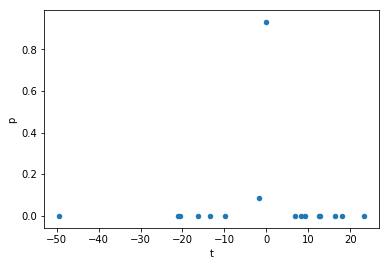

In [9]:
scores.plot.scatter(x='t', y='p')

In [10]:
means = pd.DataFrame()

for issue in votes:
    m1 = dem[issue].mean()
    m2 = rep[issue].mean()
    means.loc['dem', issue+'_mean'] = m1
    means.loc['rep', issue+'_mean'] = m2

means.T

,dem,rep
handicapped_infants_mean,0.604651,0.187879
water_project_cost_sharing_mean,0.502092,0.506757
adoption_of_the_budget_resolution_mean,0.888462,0.134146
physician_fee_freeze_mean,0.054054,0.987879
el_salvador_aid_mean,0.215686,0.951515
religious_groups_in_schools_mean,0.476744,0.897590
anti_satellite_test_ban_mean,0.772201,0.240741
aid_to_nicaraguan_contras_mean,0.828897,0.152866
mx_missile_mean,0.758065,0.115152
immigration_mean,0.471483,0.557576


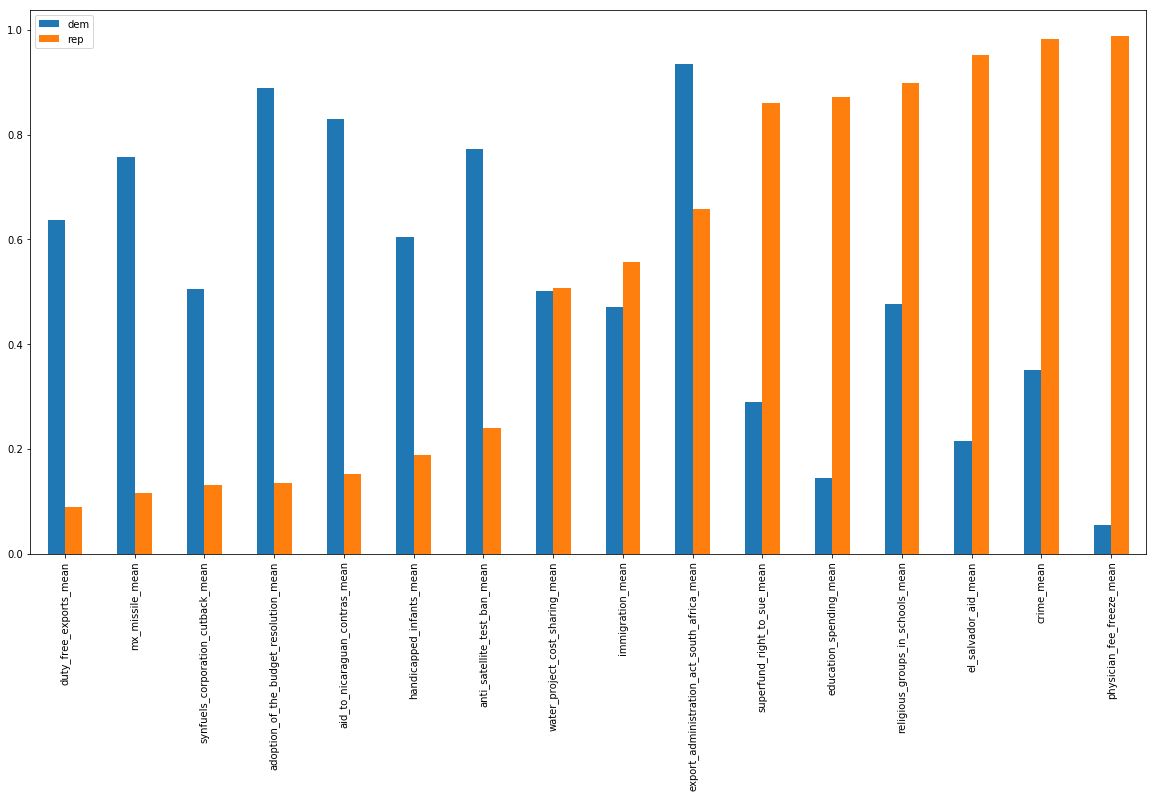

In [180]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = means.T.sort_values(by='rep').plot.bar(ax=ax)

In [12]:
confidence = 0.95
confidences = pd.DataFrame()

for issue in dem.describe():    
    confidences.loc[issue, 'dem_count'] = dem[issue].size
    confidences.loc[issue, 'rep_count'] = rep[issue].size
    confidences.loc[issue, 'dem_mean'] = dem[issue].mean()
    confidences.loc[issue, 'rep_mean'] = rep[issue].mean()
    confidences.loc[issue, 'dem_interval'] = s.stats.sem(dem[issue], nan_policy='omit')*s.stats.t.ppf((1+confidence)/2, dem[issue].size-1)
    confidences.loc[issue, 'rep_interval'] = s.stats.sem(rep[issue], nan_policy='omit')*s.stats.t.ppf((1+confidence)/2, rep[issue].size-1)
    confidences.loc[issue, 'dem_upper'] = confidences.loc[issue, 'dem_mean'] + confidences.loc[issue, 'dem_interval']
    confidences.loc[issue, 'rep_upper'] = confidences.loc[issue, 'rep_mean'] + confidences.loc[issue, 'rep_interval']
    confidences.loc[issue, 'dem_lower'] = confidences.loc[issue, 'dem_mean'] - confidences.loc[issue, 'dem_interval']
    confidences.loc[issue, 'rep_lower'] = confidences.loc[issue, 'rep_mean'] - confidences.loc[issue, 'rep_interval']

In [13]:
confidences

,dem_count,rep_count,dem_mean,rep_mean,dem_interval,rep_interval,dem_upper,rep_upper,dem_lower,rep_lower
handicapped_infants,267.0,168.0,0.604651,0.187879,0.060049,0.060219,0.664700,0.248098,0.544602,0.127660
water_project_cost_sharing,267.0,168.0,0.502092,0.506757,0.063813,0.081410,0.565905,0.588167,0.438279,0.425347
adoption_of_the_budget_resolution,267.0,168.0,0.888462,0.134146,0.038513,0.052702,0.926975,0.186848,0.849948,0.081445
physician_fee_freeze,267.0,168.0,0.054054,0.987879,0.027718,0.016870,0.081772,1.004749,0.026336,0.971009
el_salvador_aid,267.0,168.0,0.215686,0.951515,0.050812,0.033113,0.266498,0.984628,0.164874,0.918402
religious_groups_in_schools,267.0,168.0,0.476744,0.897590,0.061343,0.046599,0.538087,0.944189,0.415402,0.850992
anti_satellite_test_ban,267.0,168.0,0.772201,0.240741,0.051411,0.066522,0.823612,0.307262,0.720789,0.174219
aid_to_nicaraguan_contras,267.0,168.0,0.828897,0.152866,0.045810,0.056882,0.874707,0.209748,0.783088,0.095984
mx_missile,267.0,168.0,0.758065,0.115152,0.053652,0.049210,0.811716,0.164362,0.704413,0.065941
immigration,267.0,168.0,0.471483,0.557576,0.060721,0.076570,0.532204,0.634145,0.410762,0.481006


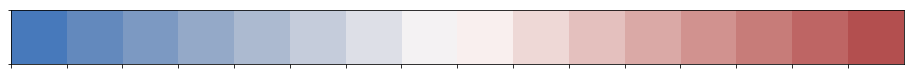

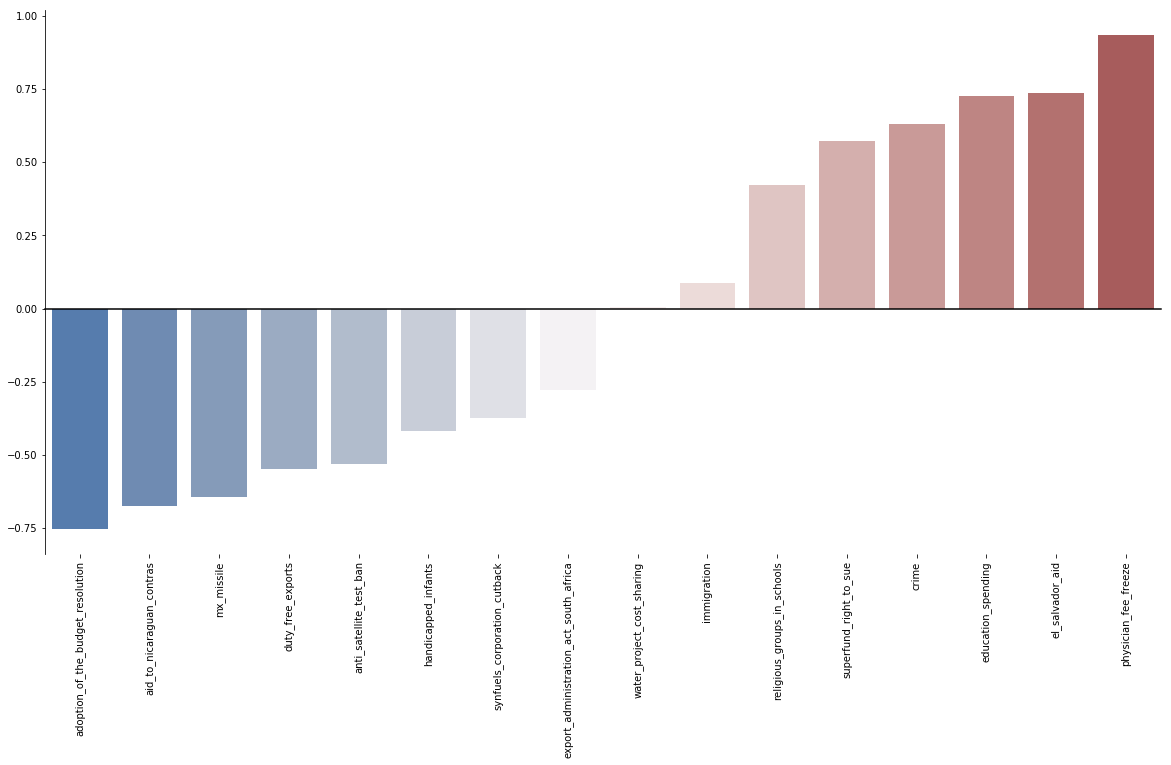

In [39]:
# The degree to which the average republican voted for a policy

divergence = (confidences['rep_mean'] - confidences['dem_mean']).sort_values()

sns.palplot(sns.color_palette("vlag", divergence.size))

fig, ax = plt.subplots(figsize=(20, 10))
bx = sns.barplot(x=divergence.index, y=divergence, palette="vlag", ax=ax)
bx.set_xticklabels(labels=divergence.index, rotation=90);
ax.axhline(0, color="k", clip_on=False)
sns.despine(bottom=True)

In [130]:
dem = votes.loc['democrat'].describe().T.assign(party='democrat').reset_index().rename(columns={'index': 'issue'})
rep = votes.loc['republican'].describe().T.assign(party='republican').reset_index().rename(columns={'index': 'issue'})

records = dem.append(rep)
records.index = pd.RangeIndex(len(records.index))

records['ttest'] = records.apply(lambda : , axis=1)
records['confidence'] = 0.95
records['standard_error'] = records.apply(lambda row: s.stats.sem(votes.loc[row.loc['party'], row.loc['issue']], nan_policy='omit'), axis=1)
records['interval'] = records['standard_error'] * s.stats.t.ppf((1+records['confidence'])/2, records['count']-1)
records['upper'] = records['mean'] + records['interval']
records['lower'] = records['mean'] - records['interval']

records

,issue,count,mean,std,min,25%,50%,75%,max,party,confidence,standard_error,interval,upper,lower
0,handicapped_infants,258.0,0.604651,0.489876,0.0,0.0,1.0,1.0,1.0,democrat,0.95,0.030498,0.060058,0.664710,0.544593
1,water_project_cost_sharing,239.0,0.502092,0.501045,0.0,0.0,1.0,1.0,1.0,democrat,0.95,0.032410,0.063847,0.565939,0.438245
2,adoption_of_the_budget_resolution,260.0,0.888462,0.315405,0.0,1.0,1.0,1.0,1.0,democrat,0.95,0.019561,0.038518,0.926980,0.849944
3,physician_fee_freeze,259.0,0.054054,0.226562,0.0,0.0,0.0,0.0,1.0,democrat,0.95,0.014078,0.027722,0.081776,0.026332
4,el_salvador_aid,255.0,0.215686,0.412106,0.0,0.0,0.0,0.0,1.0,democrat,0.95,0.025807,0.050823,0.266509,0.164863
5,religious_groups_in_schools,258.0,0.476744,0.500430,0.0,0.0,0.0,1.0,1.0,democrat,0.95,0.031155,0.061352,0.538097,0.415392
6,anti_satellite_test_ban,259.0,0.772201,0.420224,0.0,1.0,1.0,1.0,1.0,democrat,0.95,0.026111,0.051419,0.823620,0.720782
7,aid_to_nicaraguan_contras,263.0,0.828897,0.377317,0.0,1.0,1.0,1.0,1.0,democrat,0.95,0.023266,0.045813,0.874710,0.783085
8,mx_missile,248.0,0.758065,0.429121,0.0,1.0,1.0,1.0,1.0,democrat,0.95,0.027249,0.053671,0.811735,0.704394
9,immigration,263.0,0.471483,0.500138,0.0,0.0,0.0,1.0,1.0,democrat,0.95,0.030840,0.060725,0.532208,0.410757
